In [ ]:
import pandas as pd
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
nltk.download('punkt')
nltk.download('stopwords')
import math
import json
import csv
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 1. Pre-processing

In [ ]:
# stemming tool from nltk
stemmer = PorterStemmer()
# a mapping dictionary that help remove punctuations
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)
def get_tokens(text):
    # turn document into lowercase
    lowers = text.lower()
    # remove punctuations
    no_punctuation = lowers.translate(remove_punctuation_map)
    # tokenize document
    tokens = nltk.word_tokenize(no_punctuation)
    # remove stop words
    filtered = [w for w in tokens if not w in stopwords.words('english')]
    # stemming process
    stemmed = [];
    for item in filtered:
        stemmed.append(stemmer.stem(item))
    # final unigrams
    return stemmed

In [ ]:

csvPath = '24_train_1.csv';
df = pd.read_csv(csvPath);
def preprocess(csvPath):
  df = pd.read_csv(csvPath);

  filePath = 'dictionary.txt'
  with open(filePath, 'r') as file:
      wordDict = file.read()
  wordDict = wordDict.split()

  # Finding a list of all documents
  df
  docList = df["Text"].tolist()
  docList = np.array(docList)

  # Converting docList to array of unigrams
  unigramArray = [];
  i = 0
  for document in docList:
      if(i % 100 == 0):
        print(i)
      i+=1;
      tokens = get_tokens(document);
      commonSubset = [word for word in tokens if word in wordDict];
      unigramArray.append(commonSubset)

  wordCountInDocs = np.zeros(1000)
  i = 0
  for unigram in unigramArray:
      i+=1;
      j = 0
      for word in wordDict:
          if word in unigram:
              wordCountInDocs[j] += 1
          j += 1

  max_word_counts_array = []

  # Loop through each list in unigramArray
  for document_unigram in unigramArray:
      # Calculate counts of the most occurring word
      max_word_count = max(document_unigram.count(word) for word in set(document_unigram))

      # Append the count to the array
      max_word_counts_array.append(max_word_count)

  IDF = np.log(len(unigramArray) / wordCountInDocs)
  TFIDF = [];
  i = 0;
  for unigram in unigramArray:
      TF = [];
      j = 0
      for word in wordDict:
          wordCount = unigram.count(word);
          tfidfCalc = (wordCount / max_word_counts_array[i]) * IDF[j]
          TF.append(tfidfCalc);
          j += 1;
      i+=1;
      TFIDF.append(TF)

  TFIDF = np.array(TFIDF)
  return TFIDF;

## 2.1

0
100
200
300
400
500
600
700
800
900


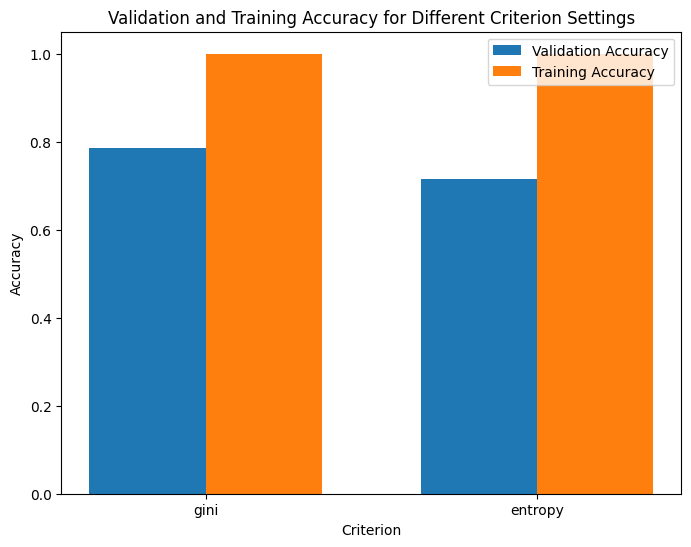

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


labels = df['Category'].values
TFIDF = preprocess(csvPath);
# Split the data into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(TFIDF, labels, test_size=0.2, random_state=42)

# Define different criterion settings
criterion_values = ["gini", "entropy"]

# Initialize lists to store training and validation accuracies
training_accuracies = []
validation_accuracies = []

# Loop through different criterion settings
for criterion in criterion_values:
    # Create and train the decision tree classifier
    dt_classifier = DecisionTreeClassifier(criterion=criterion, random_state=42)
    dt_classifier.fit(X_train, y_train)

    # Make predictions on training and validation sets
    y_train_pred = dt_classifier.predict(X_train)
    y_val_pred = dt_classifier.predict(X_val)

    # Calculate accuracies
    training_accuracy = accuracy_score(y_train, y_train_pred)
    validation_accuracy = accuracy_score(y_val, y_val_pred)

    # Append accuracies to lists
    training_accuracies.append(training_accuracy)
    validation_accuracies.append(validation_accuracy)

# Plotting grouped bar chart with swapped roles
bar_width = 0.35
index = np.arange(len(criterion_values))

fig, ax = plt.subplots(figsize=(8, 6))
bar1 = ax.bar(index, validation_accuracies, bar_width, label='Validation Accuracy')
bar2 = ax.bar(index + bar_width, training_accuracies, bar_width, label='Training Accuracy')

ax.set_xlabel('Criterion')
ax.set_ylabel('Accuracy')
ax.set_title('Validation and Training Accuracy for Different Criterion Settings')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(criterion_values)
ax.legend()

plt.show()


## 2.2.1
Decision Tree - minimum samples at leaf

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

train_val_X = np.vstack((X_train, X_val))
train_val_y = np.concatenate((y_train, y_val))

def dtc_parameter_tune(train_val_X, train_val_y):
    min_samples_leaves = [10, 25, 50, 75, 100, 125, 150, 175, 200]
    train_acc_all = []
    val_acc_all = []

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Looping over hyperparameters
    for min_samples_leaf_i in min_samples_leaves:
        train_acc = []
        val_acc = []

        # Looping over the 5 folds
        for train_index, val_index in kf.split(train_val_X):
            train_X, val_X = train_val_X[train_index, :], train_val_X[val_index, :]
            train_y, val_y = train_val_y[train_index], train_val_y[val_index]

            dtc = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf_i)
            dtc.fit(train_X, train_y)
            train_acc.append(dtc.score(train_X, train_y))
            val_acc.append(dtc.score(val_X, val_y))

        avg_train_acc = np.mean(train_acc)
        std_train_acc = np.std(train_acc)
        avg_val_acc = np.mean(val_acc)
        std_val_acc = np.std(val_acc)

        train_acc_all.append((avg_train_acc, std_train_acc))
        val_acc_all.append((avg_val_acc, std_val_acc))

    return min_samples_leaves, train_acc_all, val_acc_all

min_samples_leaves, train_acc_all, val_acc_all = dtc_parameter_tune(train_val_X, train_val_y)

# Display results in a table
results_table = pd.DataFrame({
    'min_samples_leaf': min_samples_leaves,
    'avg_training_accuracy': [acc[0] for acc in train_acc_all],
    'std_training_accuracy': [acc[1] for acc in train_acc_all],
    'avg_validation_accuracy': [acc[0] for acc in val_acc_all],
    'std_validation_accuracy': [acc[1] for acc in val_acc_all]
})

print(results_table)


   min_samples_leaf  avg_training_accuracy  std_training_accuracy  \
0                10                0.86775               0.006093   
1                25                0.77125               0.013555   
2                50                0.71950               0.007357   
3                75                0.65475               0.014841   
4               100                0.57825               0.026886   
5               125                0.50825               0.005948   
6               150                0.49475               0.015600   
7               175                0.44150               0.007722   
8               200                0.37325               0.005397   

   avg_validation_accuracy  std_validation_accuracy  
0                    0.772                 0.015033  
1                    0.724                 0.011576  
2                    0.688                 0.006000  
3                    0.612                 0.038026  
4                    0.543             

## 2.2.2

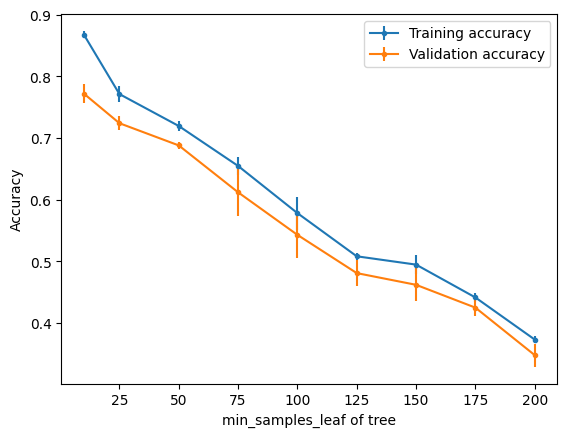

In [ ]:

# Plot training/validation curves
plt.errorbar(min_samples_leaves, [acc[0] for acc in train_acc_all], yerr=[acc[1] for acc in train_acc_all], marker='.', label="Training accuracy")
plt.errorbar(min_samples_leaves, [acc[0] for acc in val_acc_all], yerr=[acc[1] for acc in val_acc_all], marker='.', label="Validation accuracy")
plt.xlabel('min_samples_leaf of tree')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 2.3
Decision trees - max_features

    max_features  avg_training_accuracy  std_training_accuracy  \
0              1                    1.0                    0.0   
1             10                    1.0                    0.0   
2             50                    1.0                    0.0   
3            100                    1.0                    0.0   
4            150                    1.0                    0.0   
5            250                    1.0                    0.0   
6            450                    1.0                    0.0   
7            500                    1.0                    0.0   
8            600                    1.0                    0.0   
9            720                    1.0                    0.0   
10           830                    1.0                    0.0   
11           950                    1.0                    0.0   
12          1000                    1.0                    0.0   

    avg_validation_accuracy  std_validation_accuracy  
0                   

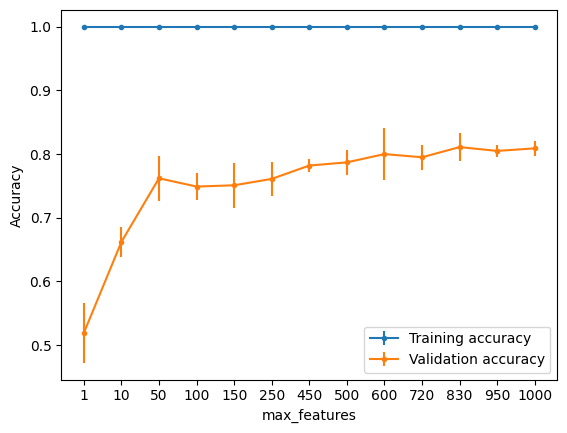

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

train_val_X = np.vstack((X_train, X_val))
train_val_y = np.concatenate((y_train, y_val))

def dtc_parameter_tune(train_val_X, train_val_y, param_values, param_name):
    train_acc_all = []
    val_acc_all = []

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for param_value in param_values:
        train_acc = []
        val_acc = []

        for train_index, val_index in kf.split(train_val_X):
            train_X, val_X = train_val_X[train_index, :], train_val_X[val_index, :]
            train_y, val_y = train_val_y[train_index], train_val_y[val_index]

            dtc = DecisionTreeClassifier(**{param_name: param_value})
            dtc.fit(train_X, train_y)
            train_acc.append(dtc.score(train_X, train_y))
            val_acc.append(dtc.score(val_X, val_y))

        avg_train_acc = np.mean(train_acc)
        std_train_acc = np.std(train_acc)
        avg_val_acc = np.mean(val_acc)
        std_val_acc = np.std(val_acc)

        train_acc_all.append((avg_train_acc, std_train_acc))
        val_acc_all.append((avg_val_acc, std_val_acc))

    return param_values, train_acc_all, val_acc_all

# Specify values for max_features parameter (you can modify this as needed)
# max_features_values = [None, 'sqrt', 'alog2', 0.5]
max_features_values = [1, 10, 50, 100, 150, 250, 450, 500, 600, 720, 830, 950, 1000]

max_features_values, train_acc_all, val_acc_all = dtc_parameter_tune(train_val_X, train_val_y, max_features_values, 'max_features')

# Display results in a table
results_table = pd.DataFrame({
    'max_features': max_features_values,
    'avg_training_accuracy': [acc[0] for acc in train_acc_all],
    'std_training_accuracy': [acc[1] for acc in train_acc_all],
    'avg_validation_accuracy': [acc[0] for acc in val_acc_all],
    'std_validation_accuracy': [acc[1] for acc in val_acc_all]
})

print(results_table)

# Plot training/validation curves
# max_features_values = ['None', 'sqrt', 'log2', '0.5']
max_features_values = list(map(str, max_features_values))
plt.errorbar(max_features_values, [acc[0] for acc in train_acc_all], yerr=[acc[1] for acc in train_acc_all], marker='.', label="Training accuracy")
plt.errorbar(max_features_values, [acc[0] for acc in val_acc_all], yerr=[acc[1] for acc in val_acc_all], marker='.', label="Validation accuracy")
plt.xlabel('max_features')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## 3.1

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Load your pre-processed training data
# X_train and y_train represent the feature matrix and target vector

# Define Random Forest Classifier with chosen parameters
rf_classifier = RandomForestClassifier(
    n_estimators=100,  # Adjust as needed
    max_depth=None,    # Adjust as needed
    min_samples_leaf=1, # Adjust as needed
    max_features='auto',  # Adjust as needed
    random_state=42  # Set a random seed for reproducibility
)

# Evaluate the model using cross-validation
cross_val_accuracy = cross_val_score(rf_classifier, X_train, y_train, cv=5)

# Print the average and standard deviation of cross-validation accuracy
print("Average Cross-Validation Accuracy: {:.2f}%".format(100 * cross_val_accuracy.mean()))
print("Standard Deviation of Cross-Validation Accuracy: {:.2f}%".format(100 * cross_val_accuracy.std()))


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Average Cross-Validation Accuracy: 94.50%
Standard Deviation of Cross-Validation Accuracy: 1.39%


## 3.2 n_estimators

Results for different n_estimators values:
   n_estimators  avg_training_accuracy  std_training_accuracy  \
0            50                    1.0                    0.0   
1           100                    1.0                    0.0   
2           150                    1.0                    0.0   
3           200                    1.0                    0.0   
4           250                    1.0                    0.0   

   avg_validation_accuracy  std_validation_accuracy  
0                    0.933                 0.005099  
1                    0.943                 0.008718  
2                    0.949                 0.008000  
3                    0.947                 0.010296  
4                    0.943                 0.010296  


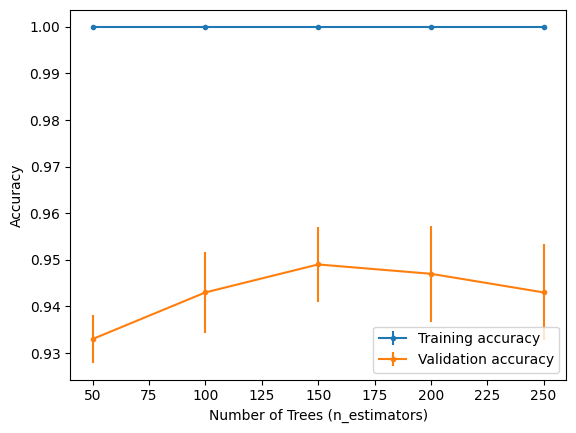

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

# Load your pre-processed training data
# X_train and y_train represent the feature matrix and target vector
train_val_X = np.vstack((X_train, X_val))
train_val_y = np.concatenate((y_train, y_val))

# Define the range of n_estimators values to evaluate
n_estimators_values = [50, 100, 150, 200, 250]

# Create empty lists to store results
avg_train_accuracies = []
std_train_accuracies = []
avg_val_accuracies = []
std_val_accuracies = []

# Perform 5-fold cross-validation for each n_estimators value
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for n_estimators in n_estimators_values:
    train_accuracies = []
    val_accuracies = []

    for train_index, val_index in kf.split(train_val_X):
        train_X, val_X = train_val_X[train_index], train_val_X[val_index]
        train_y, val_y = train_val_y[train_index], train_val_y[val_index]

        rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=42)

        # Fit on training data
        rf_classifier.fit(train_X, train_y)

        # Training accuracy
        train_accuracy = rf_classifier.score(train_X, train_y)
        train_accuracies.append(train_accuracy)

        # Validation accuracy
        val_accuracy = rf_classifier.score(val_X, val_y)
        val_accuracies.append(val_accuracy)

    # Store average and standard deviation of training accuracy
    avg_train_accuracies.append(np.mean(train_accuracies))
    std_train_accuracies.append(np.std(train_accuracies))

    # Store average and standard deviation of validation accuracy
    avg_val_accuracies.append(np.mean(val_accuracies))
    std_val_accuracies.append(np.std(val_accuracies))

# Organize the results in a table
results_table = pd.DataFrame({
    'n_estimators': n_estimators_values,
    'avg_training_accuracy': avg_train_accuracies,
    'std_training_accuracy': std_train_accuracies,
    'avg_validation_accuracy': avg_val_accuracies,
    'std_validation_accuracy': std_val_accuracies
})

# Print the results table
print("Results for different n_estimators values:")
print(results_table)

# Draw a line figure for n_estimators
plt.errorbar(n_estimators_values, avg_train_accuracies, yerr=std_train_accuracies, marker='.', label="Training accuracy")
plt.errorbar(n_estimators_values, avg_val_accuracies, yerr=std_val_accuracies, marker='.', label="Validation accuracy")
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## 3.3 min_samples_leaf_values

Results for different min_samples_leaf values:
   min_samples_leaf  avg_training_accuracy  std_training_accuracy  \
0                 1               1.000000               0.000000   
1                 5               0.991875               0.002688   
2                10               0.966250               0.003366   
3                20               0.929063               0.005467   
4                35               0.881562               0.007487   
5                50               0.759375               0.014757   

   avg_validation_accuracy  std_validation_accuracy  
0                  0.93750                 0.025000  
1                  0.93125                 0.024044  
2                  0.92250                 0.029208  
3                  0.90375                 0.026984  
4                  0.85500                 0.015000  
5                  0.69625                 0.032740  


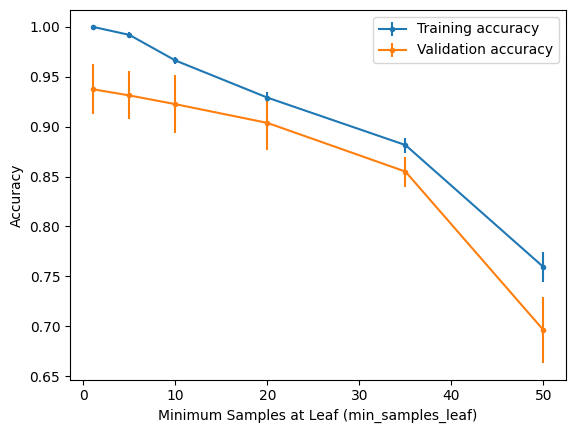

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

# Load your pre-processed training data
# X_train and y_train are NumPy arrays representing the feature matrix and target vector
train_val_X = np.vstack((X_train, X_val))
train_val_y = np.concatenate((y_train, y_val))

# Define the range of min_samples_leaf values to evaluate
min_samples_leaf_values = [1, 5, 10, 20, 35, 50]

# Create empty lists to store results
avg_train_accuracies = []
std_train_accuracies = []
avg_val_accuracies = []
std_val_accuracies = []

# Perform 5-fold cross-validation for each min_samples_leaf value
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for min_samples_leaf in min_samples_leaf_values:
    train_accuracies = []
    val_accuracies = []

    for train_index, val_index in kf.split(X_train):
        train_X, val_X = train_val_X[train_index], train_val_X[val_index]
        train_y, val_y = train_val_y[train_index], train_val_y[val_index]

        rf_classifier = RandomForestClassifier(min_samples_leaf=min_samples_leaf, random_state=42)

        # Fit on training data
        rf_classifier.fit(train_X, train_y)

        # Training accuracy
        train_accuracy = rf_classifier.score(train_X, train_y)
        train_accuracies.append(train_accuracy)

        # Validation accuracy
        val_accuracy = rf_classifier.score(val_X, val_y)
        val_accuracies.append(val_accuracy)

    # Store average and standard deviation of training accuracy
    avg_train_accuracies.append(np.mean(train_accuracies))
    std_train_accuracies.append(np.std(train_accuracies))

    # Store average and standard deviation of validation accuracy
    avg_val_accuracies.append(np.mean(val_accuracies))
    std_val_accuracies.append(np.std(val_accuracies))

# Organize the results in a table
results_table = pd.DataFrame({
    'min_samples_leaf': min_samples_leaf_values,
    'avg_training_accuracy': avg_train_accuracies,
    'std_training_accuracy': std_train_accuracies,
    'avg_validation_accuracy': avg_val_accuracies,
    'std_validation_accuracy': std_val_accuracies
})

# Print the results table
print("Results for different min_samples_leaf values:")
print(results_table)

# Draw a line figure for min_samples_leaf
plt.errorbar(min_samples_leaf_values, avg_train_accuracies, yerr=std_train_accuracies, marker='.', label="Training accuracy")
plt.errorbar(min_samples_leaf_values, avg_val_accuracies, yerr=std_val_accuracies, marker='.', label="Validation accuracy")
plt.xlabel('Minimum Samples at Leaf (min_samples_leaf)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## 4.1
I generated tokenized the documents using previous homework's code, which means, punctuation and stopwords were removed, and the remaining part was made to be in lower case.

Now, we can't directly operate on strings, which meant we required some sort of mapping from strings to numbers. There were many options. One of the good ones was to create a TF-IDF array, which will have words with greater significance for that document having greater TF-IDF score.

## 4.2
After running many variations of decision trees, Random forest seems ot have the highest accuracy, of around 97.8%.

We previously experimented with n_estimator minimum samples at leaf values for random forests using 5-fold cross validation, and found the best values for each. Thus, moving forward, we'd use 1 for minimum samples at leaf and 200 for n_estimators.

## 4.3 Training model on the entire training data.

In [ ]:
train_X = np.vstack((X_train, X_val))
train_y = np.concatenate((y_train, y_val))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=200, min_samples_leaf=1, random_state=42)
rf_classifier.fit(train_X, train_y)

RandomForestClassifier(n_estimators=200, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_classifier = RandomForestClassifier(n_estimators=200, min_samples_leaf=1, random_state=42)

rf_classifier.fit(train_X, train_y)

train_predictions = rf_classifier.predict(train_X)

train_accuracy = accuracy_score(train_y, train_predictions)
print("Training Accuracy:", 100*train_accuracy)


Training Accuracy: 100.0


In [ ]:
import pandas as pd

# Replace 'news-test.csv' with the actual file path of your testing data
file_path = 'news-test.csv'

# Read the testing data into a DataFrame
news_test = pd.read_csv(file_path)
TFIDF_test = preprocess(file_path);
# Display the first few rows of the DataFrame for verification
print(news_test.head())


0
100
200
300
400
500
600
700
   ArticleId                                               Text
0       1018  qpr keeper day heads for preston queens park r...
1       1319  software watching while you work software that...
2       1138  d arcy injury adds to ireland woe gordon d arc...
3        459  india s reliance family feud heats up the ongo...
4       1020  boro suffer morrison injury blow middlesbrough...


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import joblib

test_predictions = rf_classifier.predict(TFIDF_test)

labels_df = pd.DataFrame({'ArticleId': news_test['ArticleId'], 'prediction': test_predictions})

labels_df.to_csv('labels.csv', index=False)


In [ ]:
import pandas as pd

# Load the CSV files into DataFrames
file1_path = 'labels.csv'
file2_path = 'predictions.csv'

df1 = pd.read_csv(file1_path)
df2 = pd.read_csv(file2_path)

# Create a mask of differences
differences_mask = (df1.values != df2.values)

# Get the indices of differences
differences_indices = np.column_stack(np.where(differences_mask))

# Display differences
if np.any(differences_mask):
    print("Differences found at the following locations:")
    for idx in differences_indices:
        print(f"Row: {idx[0]}, Column: {idx[1]}")
else:
    print("The CSV files have identical values.")

Differences found at the following locations:
Row: 0, Column: 1
Row: 10, Column: 1
Row: 16, Column: 1
Row: 24, Column: 1
Row: 40, Column: 1
Row: 42, Column: 1
Row: 55, Column: 1
Row: 59, Column: 1
Row: 64, Column: 1
Row: 70, Column: 1
Row: 76, Column: 1
Row: 79, Column: 1
Row: 80, Column: 1
Row: 82, Column: 1
Row: 83, Column: 1
Row: 84, Column: 1
Row: 87, Column: 1
Row: 93, Column: 1
Row: 104, Column: 1
Row: 105, Column: 1
Row: 113, Column: 1
Row: 115, Column: 1
Row: 116, Column: 1
Row: 123, Column: 1
Row: 125, Column: 1
Row: 136, Column: 1
Row: 139, Column: 1
Row: 141, Column: 1
Row: 146, Column: 1
Row: 149, Column: 1
Row: 151, Column: 1
Row: 155, Column: 1
Row: 156, Column: 1
Row: 166, Column: 1
Row: 173, Column: 1
Row: 174, Column: 1
Row: 178, Column: 1
Row: 183, Column: 1
Row: 185, Column: 1
Row: 187, Column: 1
Row: 189, Column: 1
Row: 190, Column: 1
Row: 191, Column: 1
Row: 201, Column: 1
Row: 202, Column: 1
Row: 203, Column: 1
Row: 209, Column: 1
Row: 214, Column: 1
Row: 216, Col

In [ ]:

# Calculate the percentage of identical values
identical_percentage = (df1.values == df2.values).mean() * 100

print(f"The percentage of identical values is: {identical_percentage:.2f}%")

The percentage of identical values is: 87.28%
